# Pyomo.DoE: Exploratory Analysis

In [1]:
# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import TCLabExperiment, create_model, extract_results, extract_plot_results, results_summary

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

In [2]:
import pandas as pd
file = '../data/tclab_sine_test.csv'
# file = './data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


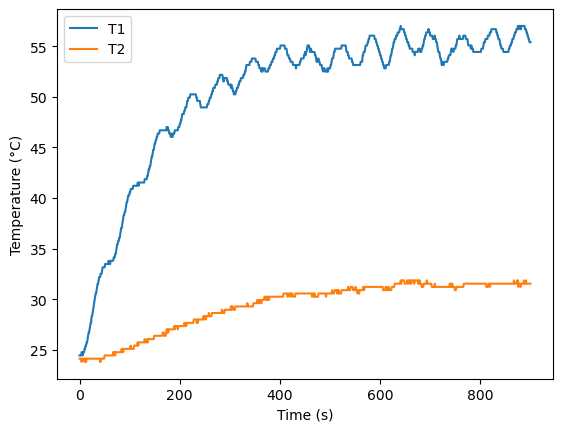

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

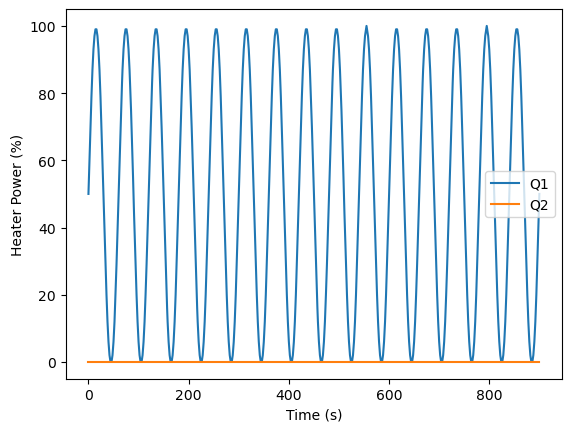

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [5]:
tc_data = TCLabExperiment(name="Sine Wave Test for Heater 1",
                            time=df['Time'].values,
                            T1=df['T1'].values,
                            u1=df['Q1'].values,
                            P1=200,
                            TS1_data=None,
                            d1 = None,
                            T2=df['T2'].values,
                            u2=df['Q2'].values,
                            P2=200,
                            TS2_data=None,
                            d2 = None,
                            Tamb=df['T1'].values[0])

## Analyze FIM with Pyomo.DoE (sine test)

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {'Ua': 0.05147278733764012, 'Ub': 0.0005342082856927798, 'inv_CpH': 0.14622879403418604, 'inv_CpS': 99.99999754623846}

In [7]:
# Get time points for control decisions
t_control = tc_data.time

measurements = MeasurementVariables()
measurements.add_variables('Ts1', 
                              indices={0: t_control},
                              time_index_position = 0)

print(measurements.variable_names)

['Ts1[0.0]', 'Ts1[1.0]', 'Ts1[2.01]', 'Ts1[3.01]', 'Ts1[4.01]', 'Ts1[5.01]', 'Ts1[6.01]', 'Ts1[7.01]', 'Ts1[8.01]', 'Ts1[9.01]', 'Ts1[10.0]', 'Ts1[11.01]', 'Ts1[12.01]', 'Ts1[13.01]', 'Ts1[14.01]', 'Ts1[15.01]', 'Ts1[16.01]', 'Ts1[17.01]', 'Ts1[18.01]', 'Ts1[19.01]', 'Ts1[20.01]', 'Ts1[21.01]', 'Ts1[22.01]', 'Ts1[23.01]', 'Ts1[24.01]', 'Ts1[25.01]', 'Ts1[26.01]', 'Ts1[27.01]', 'Ts1[28.01]', 'Ts1[29.01]', 'Ts1[30.0]', 'Ts1[31.0]', 'Ts1[32.01]', 'Ts1[33.01]', 'Ts1[34.01]', 'Ts1[35.01]', 'Ts1[36.01]', 'Ts1[37.0]', 'Ts1[38.01]', 'Ts1[39.01]', 'Ts1[40.01]', 'Ts1[41.01]', 'Ts1[42.01]', 'Ts1[43.01]', 'Ts1[44.01]', 'Ts1[45.01]', 'Ts1[46.01]', 'Ts1[47.01]', 'Ts1[48.01]', 'Ts1[49.0]', 'Ts1[50.01]', 'Ts1[51.01]', 'Ts1[52.01]', 'Ts1[53.0]', 'Ts1[54.0]', 'Ts1[55.01]', 'Ts1[56.01]', 'Ts1[57.01]', 'Ts1[58.01]', 'Ts1[59.01]', 'Ts1[60.01]', 'Ts1[61.01]', 'Ts1[62.01]', 'Ts1[63.01]', 'Ts1[64.01]', 'Ts1[65.01]', 'Ts1[66.01]', 'Ts1[67.01]', 'Ts1[68.01]', 'Ts1[69.0]', 'Ts1[70.01]', 'Ts1[71.01]', 'Ts1[72.01]

In [8]:
decisions = DesignVariables()

decisions.add_variables('U1',
                        indices={0: t_control},
                        time_index_position = 0,
                        lower_bounds=0,
                        upper_bounds=100,
                        values=tc_data.u1)

print(decisions.variable_names)

['U1[0.0]', 'U1[1.0]', 'U1[2.01]', 'U1[3.01]', 'U1[4.01]', 'U1[5.01]', 'U1[6.01]', 'U1[7.01]', 'U1[8.01]', 'U1[9.01]', 'U1[10.0]', 'U1[11.01]', 'U1[12.01]', 'U1[13.01]', 'U1[14.01]', 'U1[15.01]', 'U1[16.01]', 'U1[17.01]', 'U1[18.01]', 'U1[19.01]', 'U1[20.01]', 'U1[21.01]', 'U1[22.01]', 'U1[23.01]', 'U1[24.01]', 'U1[25.01]', 'U1[26.01]', 'U1[27.01]', 'U1[28.01]', 'U1[29.01]', 'U1[30.0]', 'U1[31.0]', 'U1[32.01]', 'U1[33.01]', 'U1[34.01]', 'U1[35.01]', 'U1[36.01]', 'U1[37.0]', 'U1[38.01]', 'U1[39.01]', 'U1[40.01]', 'U1[41.01]', 'U1[42.01]', 'U1[43.01]', 'U1[44.01]', 'U1[45.01]', 'U1[46.01]', 'U1[47.01]', 'U1[48.01]', 'U1[49.0]', 'U1[50.01]', 'U1[51.01]', 'U1[52.01]', 'U1[53.0]', 'U1[54.0]', 'U1[55.01]', 'U1[56.01]', 'U1[57.01]', 'U1[58.01]', 'U1[59.01]', 'U1[60.01]', 'U1[61.01]', 'U1[62.01]', 'U1[63.01]', 'U1[64.01]', 'U1[65.01]', 'U1[66.01]', 'U1[67.01]', 'U1[68.01]', 'U1[69.0]', 'U1[70.01]', 'U1[71.01]', 'U1[72.01]', 'U1[73.0]', 'U1[74.0]', 'U1[75.01]', 'U1[76.01]', 'U1[77.01]', 'U1[78.

In [9]:
def create_model_doe(mod=None, model_option="stage2", theta=theta_values):
    return create_model(m=mod, model_option=model_option, data=tc_data, mode='doe', theta=theta, integrate_to_initialize=True, number_of_states=number_tclab_states)

In [10]:
# Create doe_object using DesignOfExperiments
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt')
)

result = doe_object1.compute_FIM(
    mode='sequential_finite',
    formula = 'central',
    FIM_store_name = "tc_lab_fim.csv"
)
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698903678286406
D-optimality: nan
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.88459415e+08 -1.91393890e+08 -8.24201918e+06 -1.04121590e+03]
 [-1.91393890e+08  4.80931030e+09  6.51658566e+07  2.58102008e+04]
 [-8.24201918e+06  6.51658566e+07  1.46673544e+06  3.51179540e+02]
 [-1.04121590e+03  2.58102008e+04  3.51179540e+02  1.38519624e-01]]

eigenvalues:
 [ 4.81811358e+09  1.80716021e+08  4.06846518e+05 -1.88749666e-16]

eigenvectors:
 [[ 4.13259139e-02 -9.98655750e-01  3.12867703e-02 -1.01083649e-13]
 [-9.99053330e-01 -4.17276557e-02 -1.22982147e-02 -5.33299017e-06]
 [-1.35872064e-02  3.07489171e-02  9.99434786e-01 -2.48897568e-06]
 [-5.36175981e-06 -1.45999972e-07  2.42198262e-06  1.00000000e+00]]


/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:647: RuntimeWarning: invalid value encountered in log10
  print("D-optimality:", np.log10(result.det))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:648: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:649: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


## Perform sensitivity analysis

Specify a new sine way frequency.

In [13]:
def create_model_sens(mod=None, model_option="stage2", theta=theta_values):
    return create_model(m=mod, 
                        model_option=model_option, 
                        data=tc_data, 
                        mode='doe', 
                        theta=theta, 
                        integrate_to_initialize=True, 
                        number_of_states=number_tclab_states,
                        sine_frequency=1.0,
                        sine_amplitude=50)

# Get time points for control decisions
t_control = tc_data.time

measurements2 = MeasurementVariables()
measurements2.add_variables('Ts1', 
                              indices={0: t_control},
                              time_index_position = 0)

decisions2 = DesignVariables()
decisions2.add_variables('u1_frequency',
                        indices=None,
                        time_index_position = None,
                        lower_bounds=0.0001,
                        upper_bounds=1,
                        values=1.0)

decisions2.add_variables('u1_amplitude',
                        indices=None,
                        time_index_position = None,
                        lower_bounds=0,
                        upper_bounds=50,
                        values=50)


# Create doe_object using DesignOfExperiments
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions2,  # design variable
    measurements2,  # measurement variable
    create_model_sens,  # model
    solver=SolverFactory('ipopt')
)

result = doe_object2.compute_FIM(
    mode='sequential_finite',
    formula = 'central'
)
result.result_analysis()

pyomo_doe_results = extract_plot_results(tc_data, doe_object1.model)

TypeError: argument of type 'NoneType' is not iterable